# Dog Breed - annotations

This Notebook is going to make use of the annotations available in the Stanford Dog Breed Dataset.

In [53]:
from glob import iglob, glob

from tqdm import tqdm
import numpy as np
import scipy.io as sio
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from keras.applications import xception
from keras.layers import Input, Lambda, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

import xmltodict

%matplotlib inline

## Test annotations

In [2]:
doc = xmltodict.parse(open('./data/fullset/Annotation/n02116738-African_hunting_dog/n02116738_9924').read())

In [3]:
x_min, y_min = (
    int(doc['annotation']['object']['bndbox']['xmin']),
    int(doc['annotation']['object']['bndbox']['ymin']))

width = x_min + int(doc['annotation']['object']['bndbox']['xmax'])
height = y_min + int(doc['annotation']['object']['bndbox']['ymax'])

In [4]:
img = Image.open('./data/fullset/Images/n02116738-African_hunting_dog/n02116738_9924.jpg')

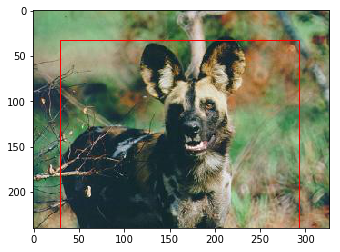

In [5]:
fig, ax = plt.subplots(1)

rect = patches.Rectangle(
    (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(rect)
    
ax.imshow(img)

## Scale bounding box with img resize

In [6]:
width_rescale = 224 / img.width

In [7]:
height_rescale = 224 / img.height

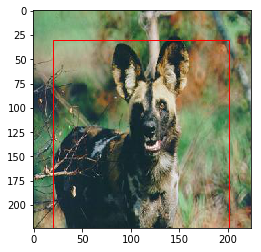

In [8]:
fig, ax = plt.subplots(1)

rect = patches.Rectangle(
    (x_min * width_rescale, y_min * height_rescale),
    width * width_rescale, height * height_rescale, linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(rect)
    
ax.imshow(img.resize((224, 224)))

## Create input features

Create a array (None, 400, 400, 3) of images and an array (None, 4) of bounding boxes. We'll need to scale down the bounding box size for each image.

In [15]:
labels = pd.read_csv('./data/labels.csv')
id_to_label = {i: label for i, label in enumerate(sorted(labels.breed.unique()))}
label_to_id = {label: i for i, label in id_to_label.items()}

num_classes = len(labels.breed.unique())
img_size = (400, 400)

In [16]:
def convert_bb(bounding_box, img, new_size):
    x_min, y_min = (
        int(bounding_box['xmin']),
        int(bounding_box['ymin']))
    width = x_min + int(bounding_box['xmax'])
    height = y_min + int(bounding_box['ymax'])
    
    new_width, new_height = new_size
    width_rescale = new_width / img.width
    height_rescale = new_height / img.height
    
    return np.asarray([
        x_min * width_rescale, y_min * height_rescale,
        width * width_rescale, height * height_rescale], dtype=np.float32)

In [32]:
n = len(glob('./data/fullset/Images/**/*.jpg', recursive=True))

X = np.zeros((n,) + img_size + (3,), dtype=np.uint8)
BB = np.zeros((n, 4), dtype=np.float32)
Y = np.zeros((n, 120), dtype=np.uint8)

for i, filename in tqdm(enumerate(iglob('./data/fullset/Images/**/*.jpg', recursive=True)), total=n):
    filepath = filename
    
    file_id = filepath.split('/')[-1][:-4]
    label_orig = filepath.split('/')[-2]
    label = label_orig[10:].lower()

    img = Image.open(filepath)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Load annotation
    annotation_path = './data/fullset/Annotation/{label_orig}/{file_id}'.format(
        label_orig=label_orig, file_id=file_id)
    doc = xmltodict.parse(open(annotation_path).read())

    label_id = label_to_id[label]
    
    obj = doc['annotation']['object']
    if isinstance(obj, list):
        obj = doc['annotation']['object'][0]
        
    bndbox = obj['bndbox']
    
    BB[i] = convert_bb(bndbox, img, img_size)
    
    img = img.resize(img_size)
    
    X[i] = np.asarray(img)
    
    Y[i][label_id] = 1

100%|██████████| 20580/20580 [02:01<00:00, 168.87it/s]


In [34]:
np.savez('./pickle/Stanford_Images_400x400.npz', X)
np.savez('./pickle/Stanford_BB.npz', BB)
np.savez('./pickle/Stanford_Labels.npz', Y)

In [45]:
X = np.load('./pickle/Stanford_Images_400x400.npz')['arr_0']
BB = np.load('./pickle/Stanford_BB.npz')['arr_0']
Y = np.load('./pickle/Stanford_Labels.npz')['arr_0']

In [46]:
def get_bottleneck_features(data, batch_size=64, img_size=(299, 299)):
    input_shape = img_size + (3,)

    base_model = xception.Xception(
        include_top=False, input_shape=input_shape, weights='imagenet')

    inp = Input(input_shape)
    x = Lambda(xception.preprocess_input, name='preprocessing')(inp)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    cnn_model = Model(inp, outputs=x)

    return cnn_model.predict(data, batch_size=batch_size, verbose=1)

In [47]:
features = get_bottleneck_features(X, img_size=(400, 400))

20580/20580 [==============================] - 912s 44ms/step


In [48]:
np.save('./pickle/Stanford_Images_400x400_bottleneck', features)

In [49]:
features = np.load('./pickle/Stanford_Images_400x400_bottleneck.npy')

In [115]:
def get_model(shape, num_classes, dropout=0):
    inp = Input(shape)
    x = Dropout(dropout)(inp)

    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(num_classes, activation='softmax', name='class')(x)

    model = Model([inp], outputs=[x_bb, x_class])
    model.compile(
        Adam(lr=0.001),
        loss=['mse', 'categorical_crossentropy'],
        metrics=['accuracy'],
        loss_weights=[.001, 1.])
    return model

In [116]:
model = get_model(features.shape[1:], num_classes, 0.5)

In [117]:
callbacks = [
    ReduceLROnPlateau(monitor='val_class_loss', patience=3, verbose=1),
    EarlyStopping(patience=5)]

indexes = np.random.permutation(len(features))

In [118]:
res = model.fit(
    features[indexes], [BB[indexes], Y[indexes]], batch_size=64,
    epochs=40, validation_split=0.1, callbacks=callbacks)

Train on 18522 samples, validate on 2058 samples
Epoch 1/40
18522/18522 [==============================] - 4s 242us/step - loss: 83.8802 - bb_loss: 82474.6644 - class_loss: 1.4056 - bb_acc: 0.4575 - class_acc: 0.8157 - val_loss: 74.6790 - val_bb_loss: 74268.9279 - val_class_loss: 0.4100 - val_bb_acc: 0.4684 - val_class_acc: 0.9247
Epoch 2/40
18522/18522 [==============================] - 3s 147us/step - loss: 68.3957 - bb_loss: 68061.1320 - class_loss: 0.3346 - bb_acc: 0.5080 - class_acc: 0.9278 - val_loss: 61.5740 - val_bb_loss: 61290.2763 - val_class_loss: 0.2837 - val_bb_acc: 0.5253 - val_class_acc: 0.9286
Epoch 3/40
18522/18522 [==============================] - 3s 145us/step - loss: 56.5026 - bb_loss: 56247.0896 - class_loss: 0.2555 - bb_acc: 0.5657 - class_acc: 0.9332 - val_loss: 50.6973 - val_bb_loss: 50448.2316 - val_class_loss: 0.2491 - val_bb_acc: 0.6122 - val_class_acc: 0.9329
Epoch 4/40
18522/18522 [==============================] - 3s 148us/step - loss: 46.4694 - bb_loss: 

18496/18522 [============================>.] - ETA: 0s - loss: 6.2668 - bb_loss: 6185.1915 - class_loss: 0.0816 - bb_acc: 0.6113 - class_acc: 0.9760
Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
18522/18522 [==============================] - 3s 147us/step - loss: 6.2674 - bb_loss: 6185.8537 - class_loss: 0.0815 - bb_acc: 0.6113 - class_acc: 0.9761 - val_loss: 5.8525 - val_bb_loss: 5642.4343 - val_class_loss: 0.2101 - val_bb_acc: 0.6132 - val_class_acc: 0.9344
Epoch 28/40
18522/18522 [==============================] - 3s 145us/step - loss: 6.2564 - bb_loss: 6174.8097 - class_loss: 0.0816 - bb_acc: 0.6113 - class_acc: 0.9760 - val_loss: 5.8525 - val_bb_loss: 5642.4339 - val_class_loss: 0.2101 - val_bb_acc: 0.6132 - val_class_acc: 0.9344
Epoch 29/40
18522/18522 [==============================] - 3s 147us/step - loss: 6.2651 - bb_loss: 6184.1555 - class_loss: 0.0810 - bb_acc: 0.6113 - class_acc: 0.9766 - val_loss: 5.8525 - val_bb_loss: 5642.4334 - val_cla

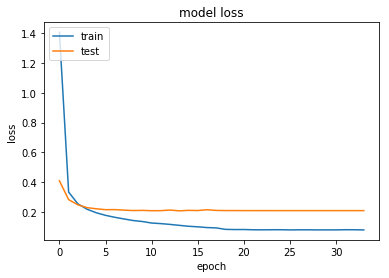

In [119]:
plt.plot(res.history['class_loss'])
plt.plot(res.history['val_class_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

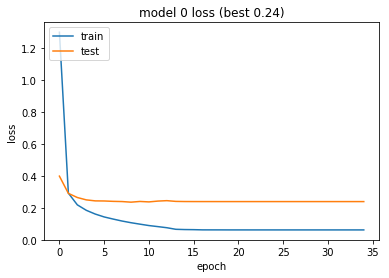

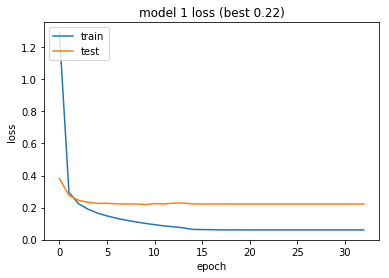

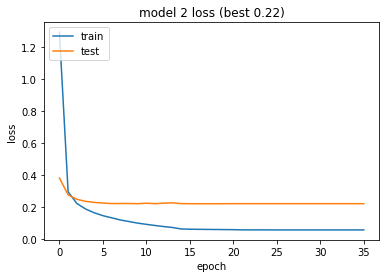

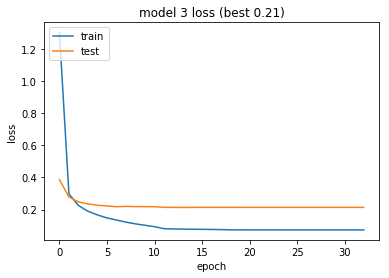

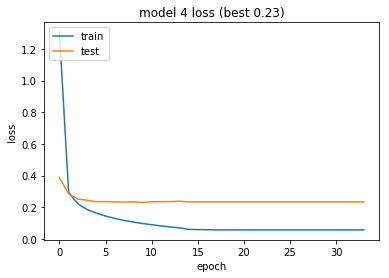

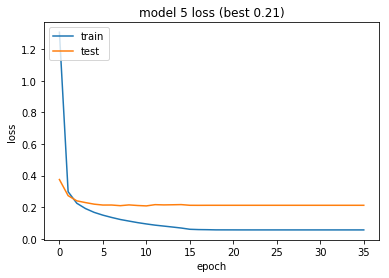

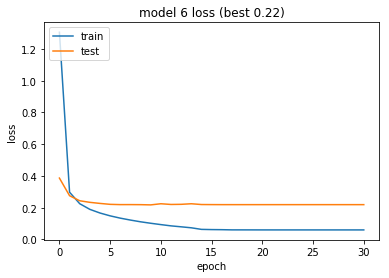

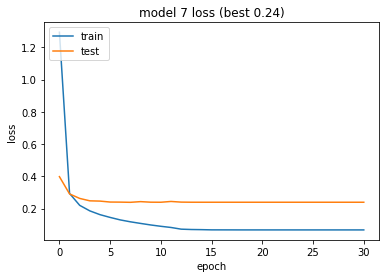

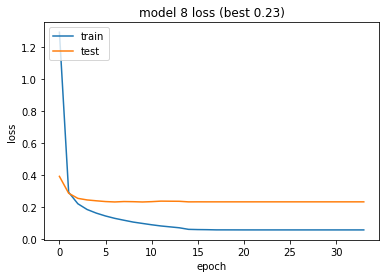

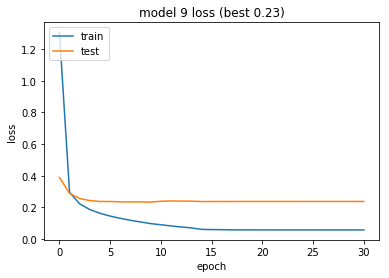

In [120]:
num_models = 10

for i in range(num_models):
    model_path = f'./checkpoints/xception_ens_fullset_400x400_bb_{i}.h5'
    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True),
        ReduceLROnPlateau(monitor='val_class_loss', patience=3, verbose=False),
        EarlyStopping(patience=5)]
    
    model = get_model(features.shape[1:], num_classes)
    
    indexes = np.random.permutation(len(features))
    
    res = model.fit(
        features[indexes], [BB[indexes], Y[indexes]], batch_size=64, epochs=40,
        validation_split=0.2, verbose=False, callbacks=callbacks)
    
    best_loss = round(min(res.history['val_class_loss']), 2)
    plt.plot(res.history['class_loss'])
    plt.plot(res.history['val_class_loss'])
    plt.title(f'model {i} loss (best {best_loss})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [121]:
def get_test_inputs(sample_df, img_size):
    n_test = len(sample_df)
    X_test = np.zeros((n_test,) + img_size + (3,), dtype=np.uint8)
    for i, row in tqdm(enumerate(sample_df.itertuples()), total=n_test):
        item_id = row.id

        img = Image.open(f'./data/test/unknown/{item_id}.jpg').resize(img_size)

        X_test[i] = np.asarray(img)
        
    return X_test

In [122]:
sample_df = pd.read_csv('./data/sample_submission.csv')

In [123]:
X_test = get_test_inputs(sample_df, img_size=img_size)

100%|██████████| 10357/10357 [00:37<00:00, 278.35it/s]


In [101]:
test_features = get_bottleneck_features(X_test, img_size=img_size)

10357/10357 [==============================] - 458s 44ms/step


In [102]:
np.save('./pickle/kaggle_bottleneck', test_features)

In [124]:
test_features = np.load('./pickle/kaggle_bottleneck.npy')

In [125]:
model = get_model(test_features.shape[1:], num_classes)

predictions = []

for i in range(10):
    model.load_weights(f'./checkpoints/xception_ens_fullset_400x400_bb_{i}.h5')
    p = model.predict(test_features)
    predictions.append(p[1])
    
avg_preds = np.stack(predictions).mean(axis=0)

In [126]:
for i in range(num_classes):
    sample_df[id_to_label[i]] = avg_preds[:,i]

In [127]:
sample_df.to_csv(
    './submissions/xception_standord_set_ensemble_400x400.csv.gz',
    index=None, compression='gzip')

In [128]:
from IPython.display import FileLink

FileLink('./submissions/xception_standord_set_ensemble_400x400.csv.gz')

/home/ubuntu/kaggle-playground/dog-breed-identification/submissions/xception_standord_set_ensemble_400x400.csv.gz

Gives me a score of 0.08506 and places me to 63rd. Better than my previous score of 0.10865. What happens if I make a 10x validation set?

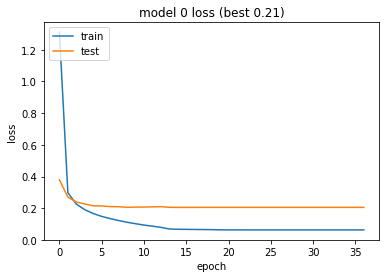

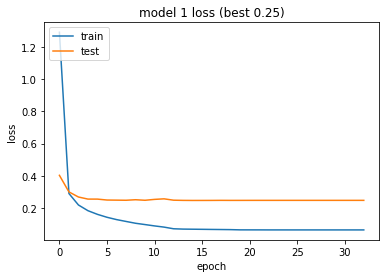

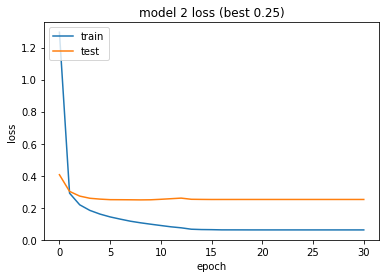

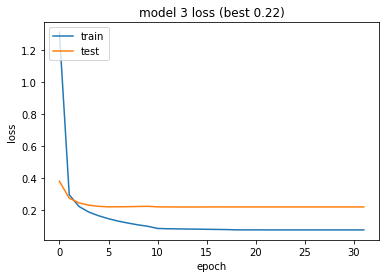

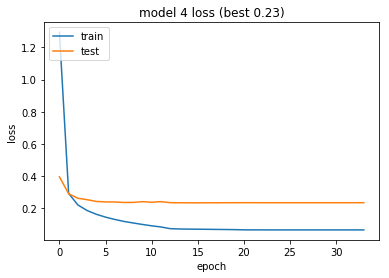

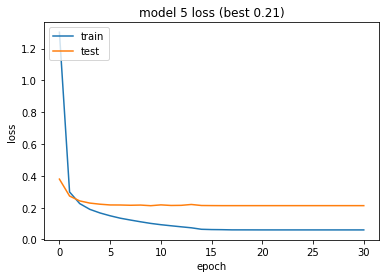

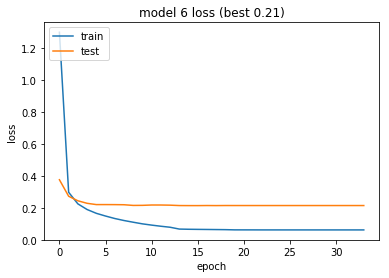

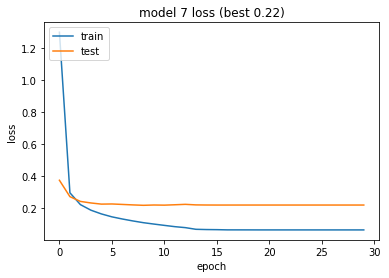

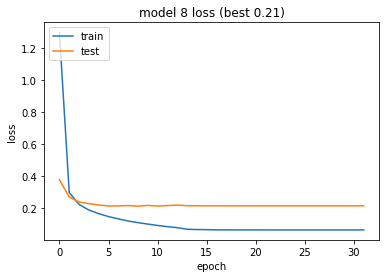

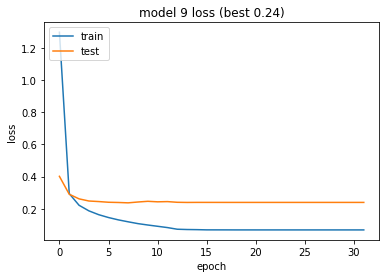

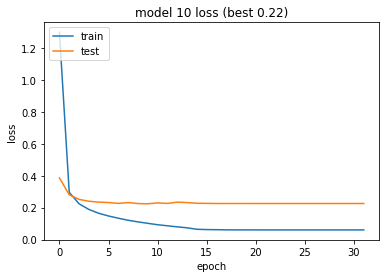

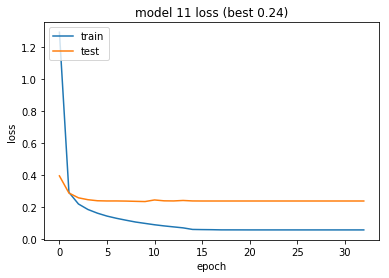

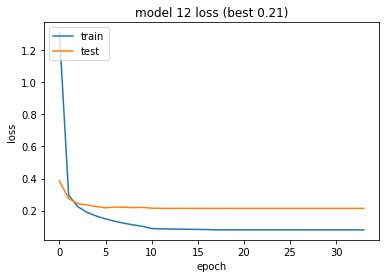

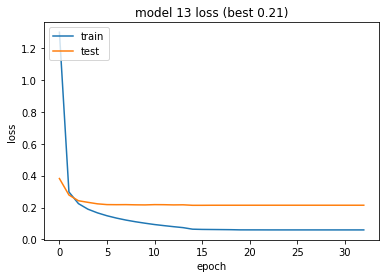

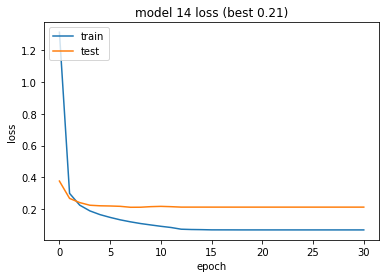

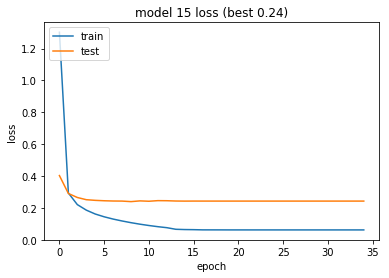

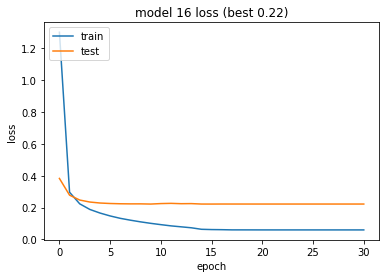

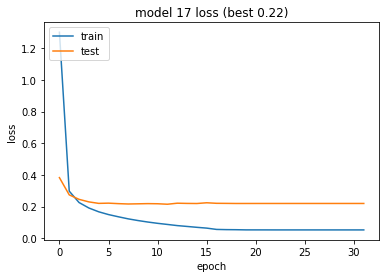

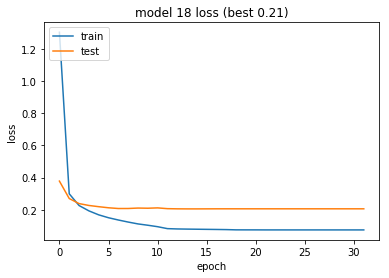

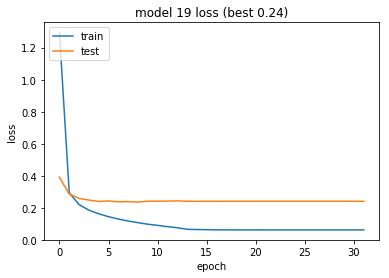

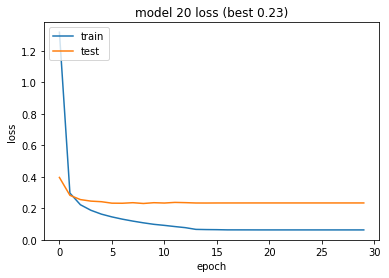

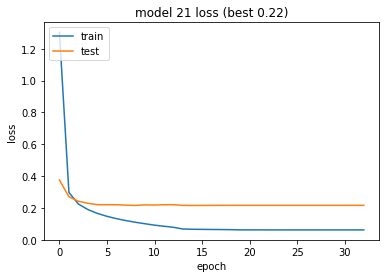

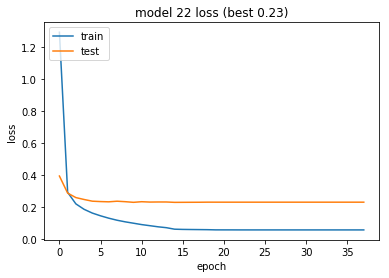

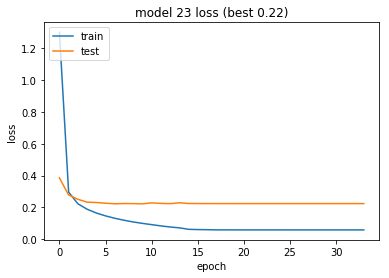

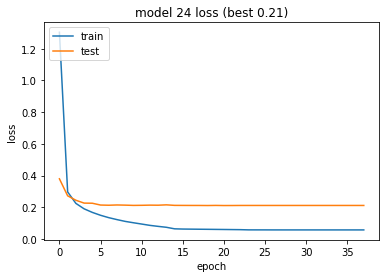

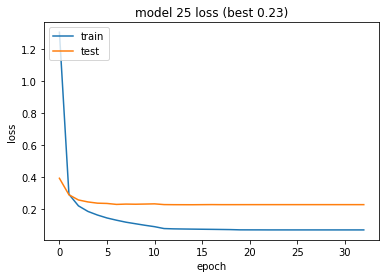

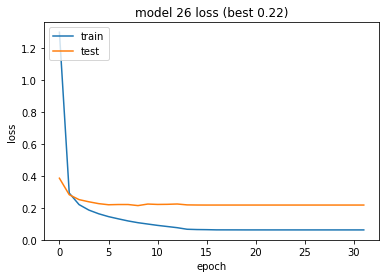

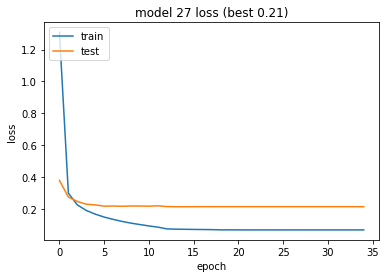

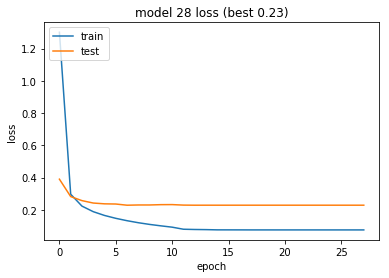

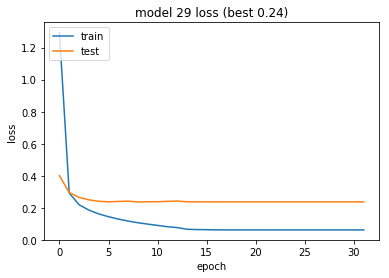

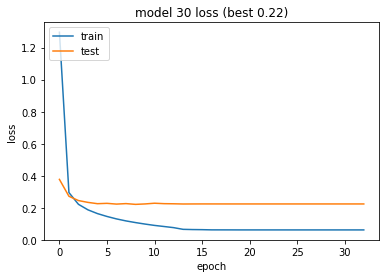

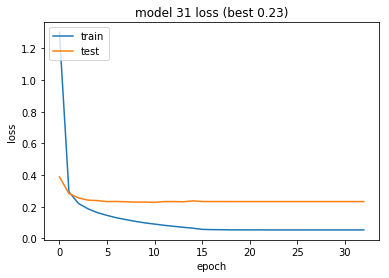

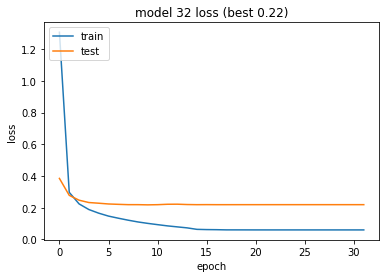

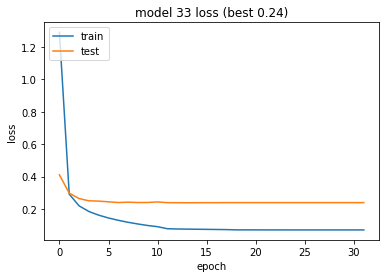

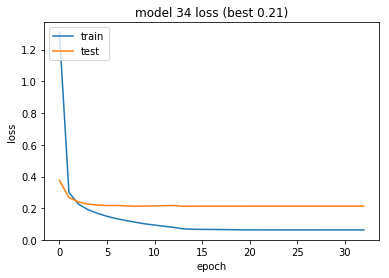

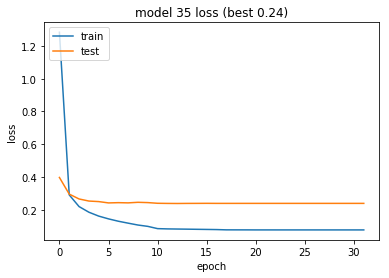

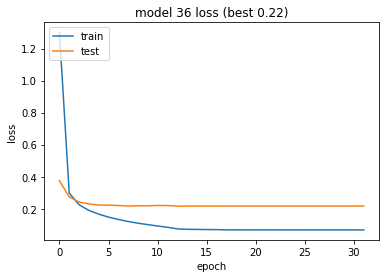

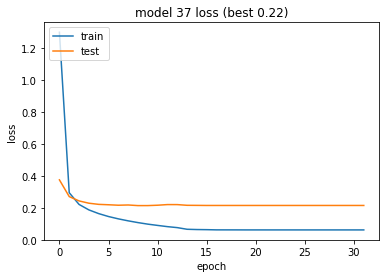

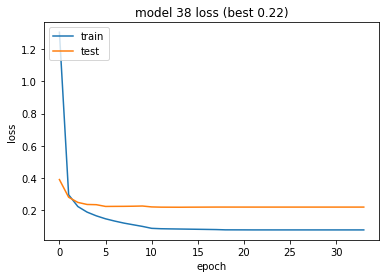

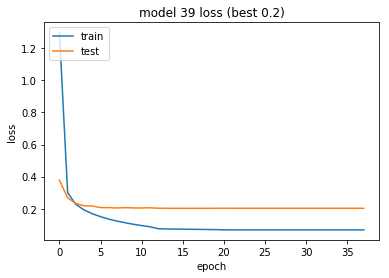

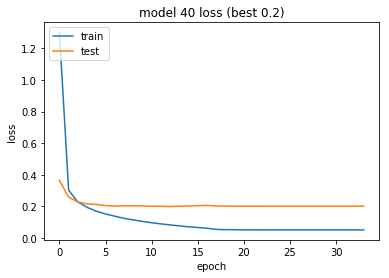

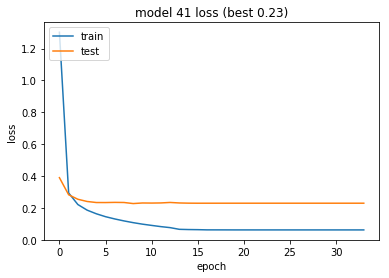

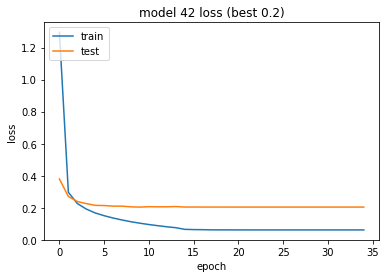

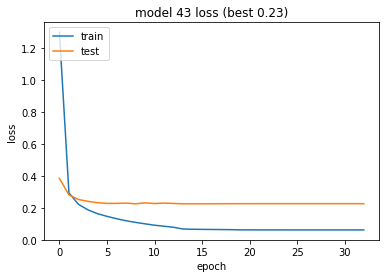

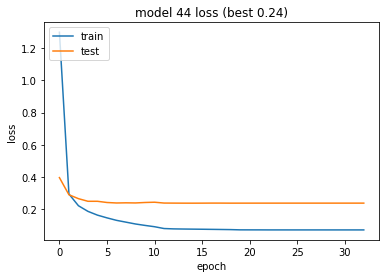

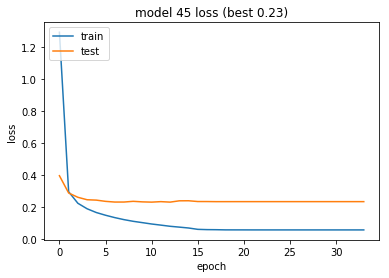

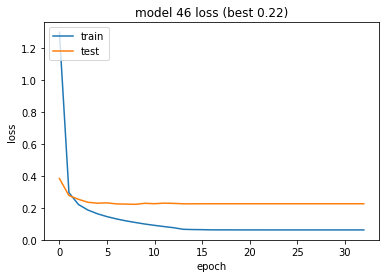

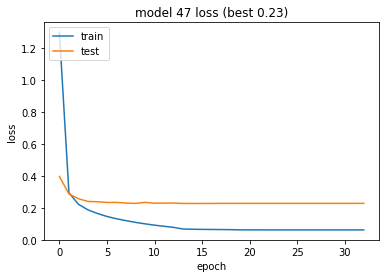

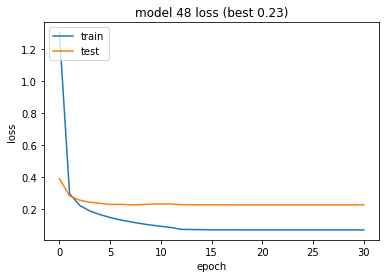

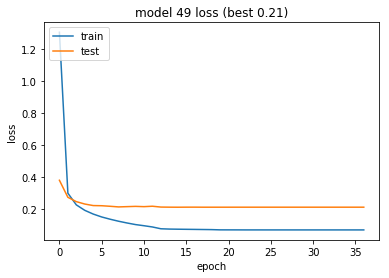

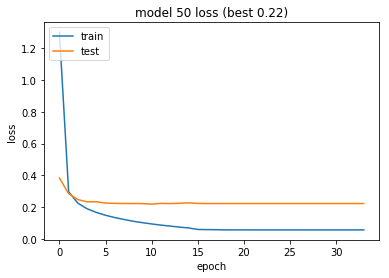

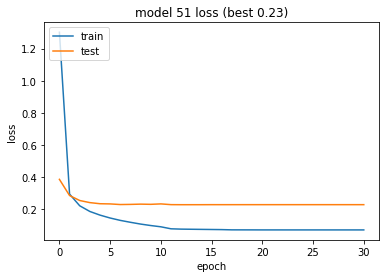

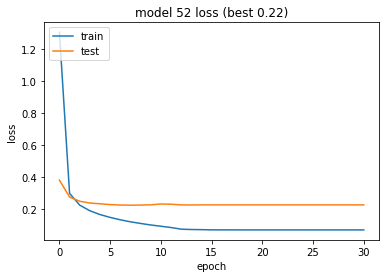

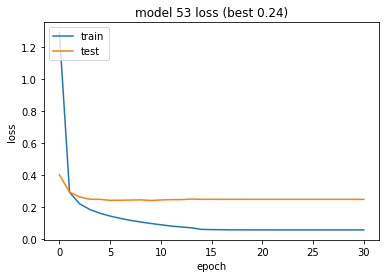

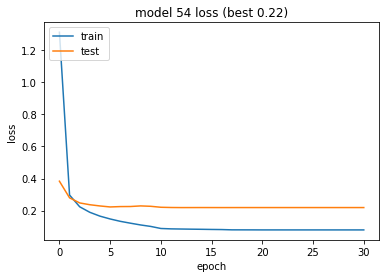

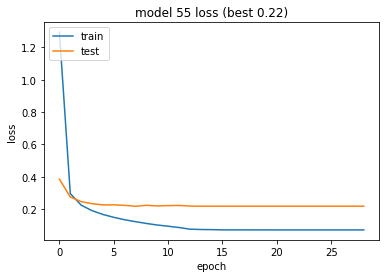

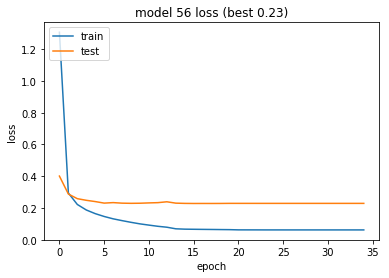

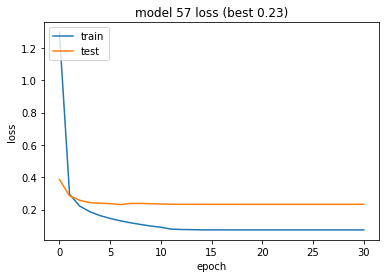

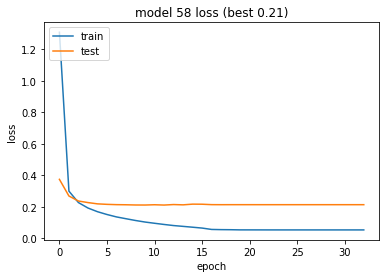

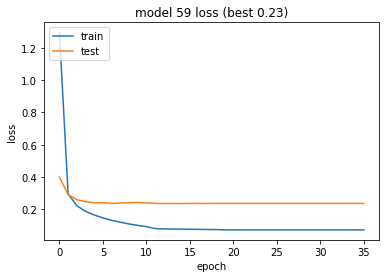

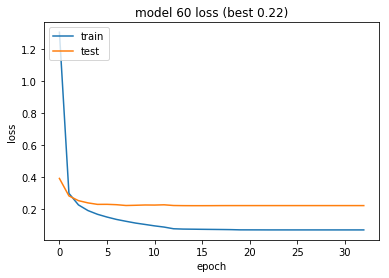

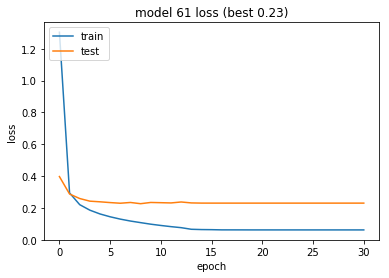

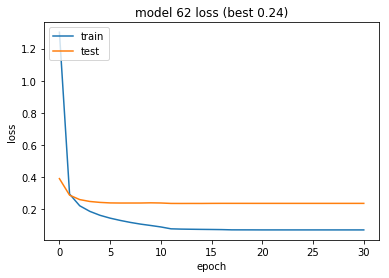

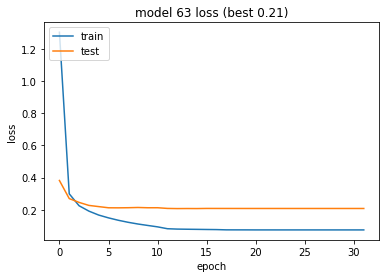

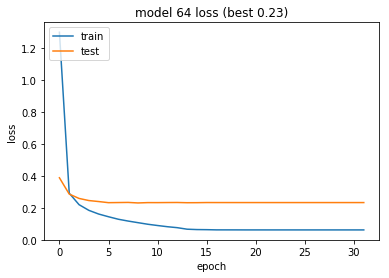

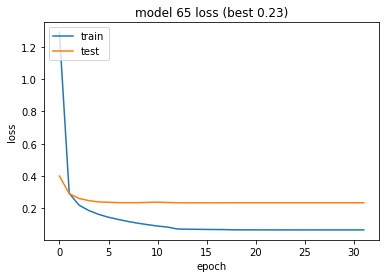

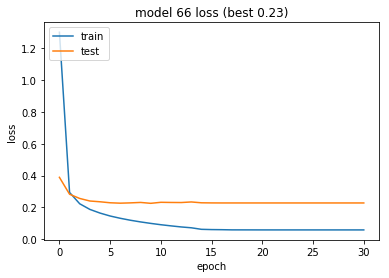

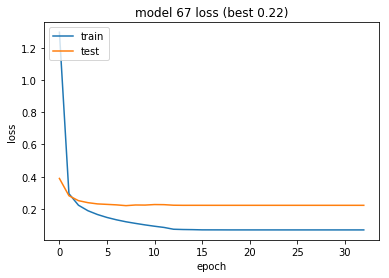

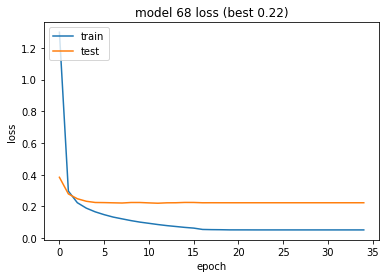

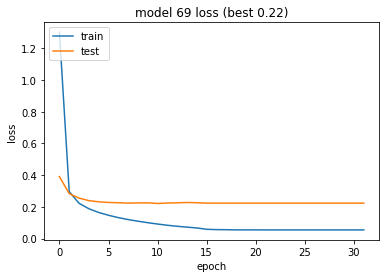

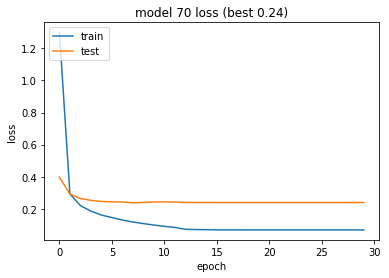

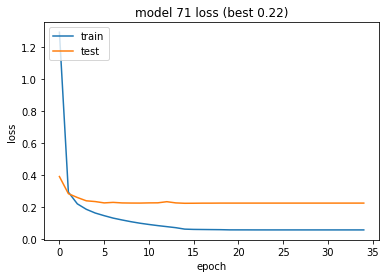

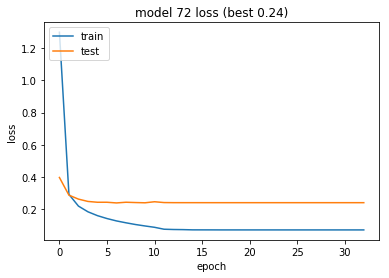

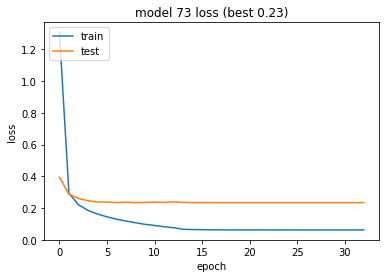

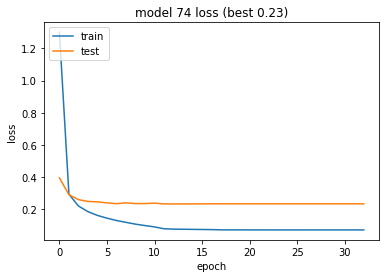

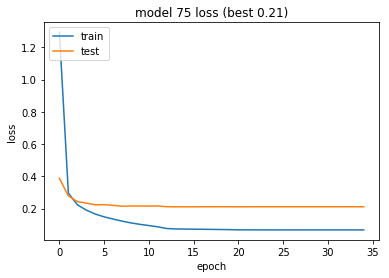

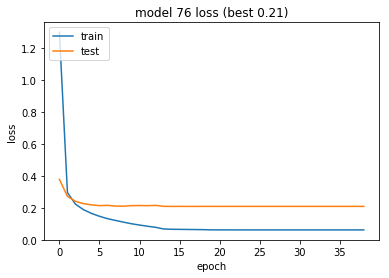

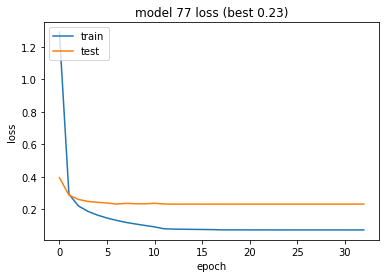

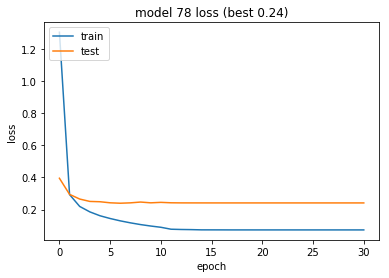

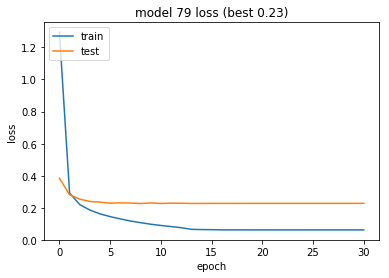

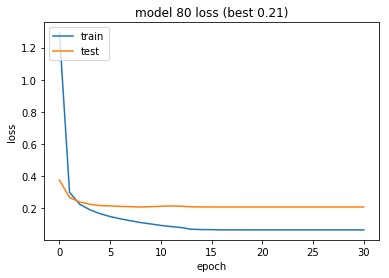

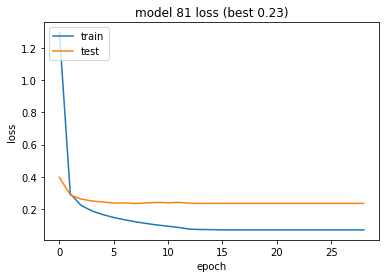

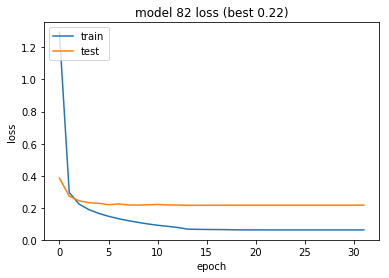

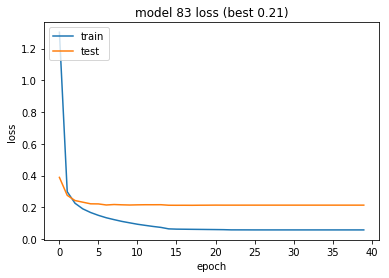

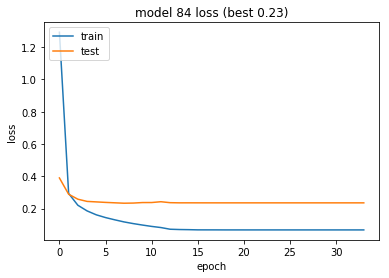

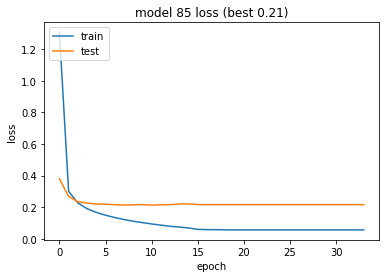

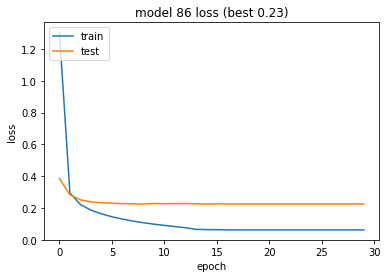

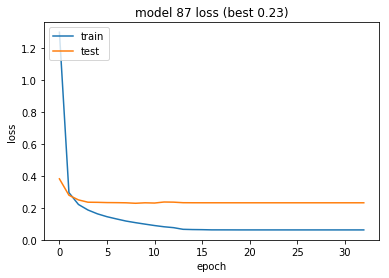

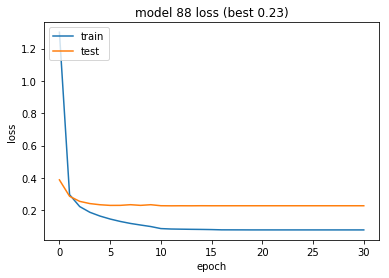

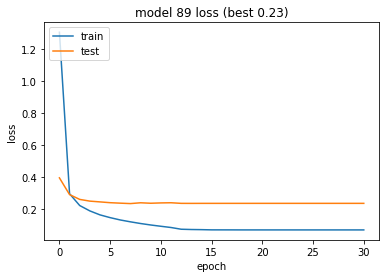

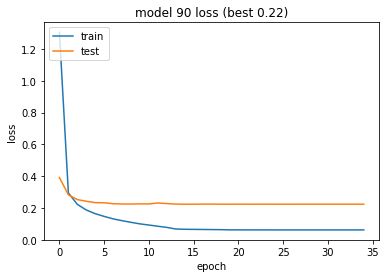

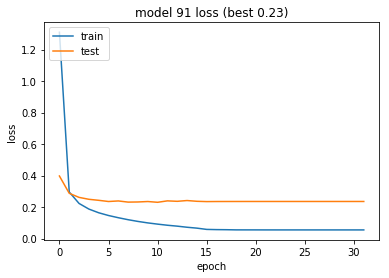

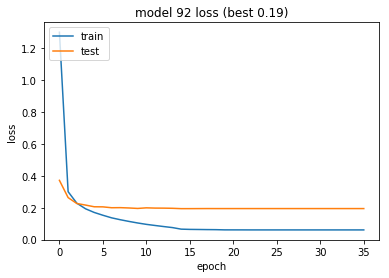

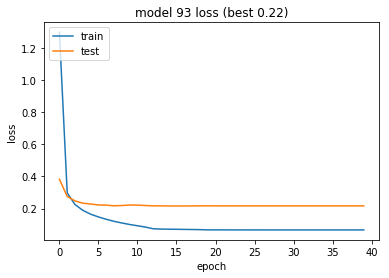

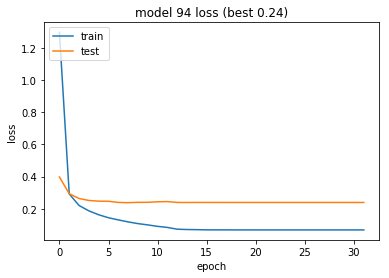

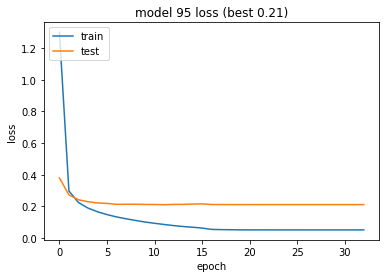

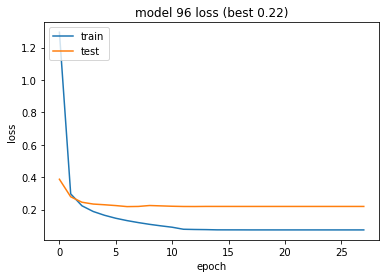

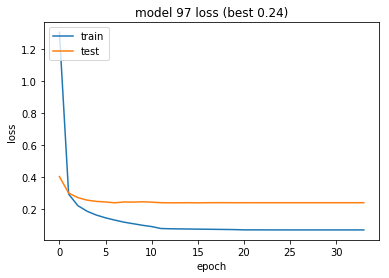

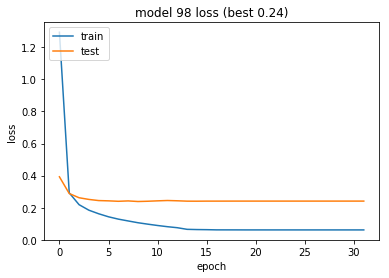

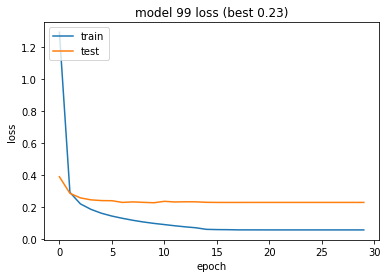

In [129]:
num_models = 100

for i in range(num_models):
    model_path = f'./checkpoints/xception_ens_fullset_400x400_bb_100_{i}.h5'
    callbacks = [
        ModelCheckpoint(model_path, save_best_only=True),
        ReduceLROnPlateau(monitor='val_class_loss', patience=3, verbose=False),
        EarlyStopping(patience=5)]
    
    model = get_model(features.shape[1:], num_classes)
    
    indexes = np.random.permutation(len(features))
    
    res = model.fit(
        features[indexes], [BB[indexes], Y[indexes]], batch_size=64, epochs=40,
        validation_split=0.2, verbose=False, callbacks=callbacks)
    
    best_loss = round(min(res.history['val_class_loss']), 2)
    plt.plot(res.history['class_loss'])
    plt.plot(res.history['val_class_loss'])
    plt.title(f'model {i} loss (best {best_loss})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [130]:
model = get_model(test_features.shape[1:], num_classes)

predictions = []

for i in range(100):
    model.load_weights(f'./checkpoints/xception_ens_fullset_400x400_bb_100_{i}.h5')
    p = model.predict(test_features)
    predictions.append(p[1])
    
avg_preds = np.stack(predictions).mean(axis=0)

In [131]:
for i in range(num_classes):
    sample_df[id_to_label[i]] = avg_preds[:,i]

In [132]:
sample_df.to_csv(
    './submissions/xception_standord_set_ensemble_400x400_100.csv.gz',
    index=None, compression='gzip')

In [133]:
from IPython.display import FileLink

FileLink('./submissions/xception_standord_set_ensemble_400x400_100.csv.gz')

/home/ubuntu/kaggle-playground/dog-breed-identification/submissions/xception_standord_set_ensemble_400x400_100.csv.gz

Didn't help, score = 0.08797, which puts me back a position.